**----------------------------------------------**

Author: Anmol Srivastava


Northeastern University

CS6140 - Machine Learning (Fall 2020)


Date - 15th December 2020

**----------------------------------------------**

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [2]:
def parallel_8_1D(x, channel, kernel, padding='same'):
    
    """
    This function is responsible for fitting Conv1D layers 
    on input data of specified kernel size i.e (2 to 9) which
    would be then combined together.
    
    Parameters:
    
    x: input tensor
    channel (int): Number of channels for Conv1D layers or filters
    kernel (int): size of kernel
    padding (str): padding type
    
    
    Return:
    resulting tensor
    """
    
    x = keras.layers.Conv1D(channel, kernel_size=kernel, padding=padding)(x)
    x = keras.layers.BatchNormalization(gamma_initializer='zeros')(x)
    return x

In [3]:
def residual_block(x,layers, kernel=(3,), act='relu', se=0, **kws):
    
    """
    This function creates the residual blocks and the squeeze-excitation
    """
    
    
    raw_x = x  # backup input

    x = keras.layers.Conv1D(layers, kernel_size=kernel, padding='same', **kws)(x)
    x = keras.layers.BatchNormalization(gamma_initializer='zeros')(x)

    if se == 1:
        x2 = keras.layers.GlobalAveragePooling1D()(x)
        x2 = keras.layers.Dense(max(4, layers // 16), activation='relu')(x2)
        x2 = keras.layers.Dense(layers, activation='sigmoid')(x2)
        x2 = keras.layers.Reshape((1, -1))(x2)

        x = keras.layers.Multiply()([x, x2])

    if K.int_shape(x)[-1] != layers:
        raw_x = ConvLayer(layers, kernel_size=1, padding='same')(raw_x)
        raw_x = normalizer()(raw_x)

    x = keras.layers.Add()([raw_x, x])

    return keras.layers.Activation(act)(x)

In [4]:
# PeptideNet Architecture

inp = keras.Input(shape=(21,25))
features = keras.layers.Concatenate(
        axis=-1)([parallel_8_1D(inp, 64, i) for i in range(2, 10)])

x = keras.layers.Conv1D(512, kernel_size=1, padding='same')(inp)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, features])
x = keras.layers.Activation('relu')(x)

for i in range(8):
    x = residual_block(x, 512, 3, act='relu', se=1)

for i in range(3):
    x = residual_block(x, 512, 1, se=0, act='relu')

x = keras.layers.Conv1D(20000, kernel_size=1, padding='valid')(x)
x = keras.layers.Activation('sigmoid')(x)
x = keras.layers.GlobalAveragePooling1D(name='spectrum')(x)

model = keras.models.Model(inputs=inp, outputs=x, name="peptide_net")

In [5]:
model.compile(keras.optimizers.Adam(0.001), loss=keras.losses.MeanSquaredError(), metrics=[keras.losses.CosineSimilarity()])

In [6]:
model.summary()

Model: "peptide_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21, 25)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 21, 64)       3264        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 21, 64)       4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 21, 64)       6464        input_1[0][0]                    
________________________________________________________________________________________

In [7]:
class DataGenerator(keras.utils.Sequence):
    
    """
    Generates the Data using path of one-hot encoding and target m/z intensities
    
    @param batch_size: size of the batch
    @param img_size: size of the one-hot encoding matrix
    @param input_image_paths: X paths
    @param target_image_path: Y paths
    @param vector_length: length of an m/z vector
    
    """
    
    def __init__(self,batch_size,img_size,input_image_paths,target_image_paths,vector_length):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_image_paths = input_image_paths
        self.target_image_paths = target_image_paths
        self.vector_length = vector_length
        
    def __len__(self):
        return len(self.target_image_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_image_paths = self.input_image_paths[i:i+self.batch_size]
        batch_target_image_paths = self.target_image_paths[i:i+self.batch_size]
        
        x = np.zeros(shape=(self.batch_size,self.img_size[0],self.img_size[1]),dtype='float64')
        
        for j,path in enumerate(batch_input_image_paths):
            seq = np.load(path)
            seq = seq[0,:,:]
            x[j] = seq
            
        y = np.zeros(shape=(self.batch_size,self.vector_length),dtype='float64')
            
        for j,path in enumerate(batch_target_image_paths):
            vect = sparse.load_npz(path).toarray()[0]
            y[j, :] = vect[:20000]
            
        return x,y

In [8]:
root_dir = '/home/srivastava.anm'

In [9]:
def generateDataset(folder):
    os.listdir(root_dir + "/" + folder)
    x_path = []
    y_path = []

    for item in os.listdir(root_dir + "/ProteomeTools"):
        if item.startswith("one"):
            x_path.append(item)
        else:
            y_path.append(item)

    x_path.sort()
    y_path.sort()
    
    if len(x_path) > len(y_path):
        x_path = x_path[:len(y_path)]
    else:
        y_path = y_path[:len(x_path)]
    
    data_dict = {"x_path":x_path, "y_path":y_path}

    data = pd.DataFrame(data_dict)
    
    data["x_path"] = data["x_path"].apply(lambda x: root_dir + "/" + folder + "/" + x)
    data["y_path"] = data["y_path"].apply(lambda x: root_dir + "/" + folder + "/" + x)
    
    return data

In [10]:
ls

data_preprocessing.py         NIST.mgf                 PeptideNet.h5
etd_predict.mgf               NIST_Synthetic/          PeptideNet.ipynb
Fast_data_processing_NIST.py  NIST_Synthetic.mgf       ProteomeTools/
hcd_predict.mgf               Num_data_clean_NIST.npy  ProteomeTools.mgf
MassIVE.mgf                   ondemand/                results.csv


In [11]:
data = generateDataset("ProteomeTools")
data_1 = generateDataset("NIST_Synthetic")
data_2 = generateDataset("NIST")
data_3 = generateDataset("MassIVE")

new_data = pd.concat([data, data_1, data_2, data_3], axis=0)

In [14]:
def split_dataset(frac, dataset):
    
    SPLIT = frac
    
    X = dataset["x_path"].values
    y = dataset["y_path"].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= SPLIT)
    
    return (X_train, X_test, y_train, y_test)

In [15]:
stratified_data = split_dataset(0.25, data)

In [16]:
train_gen = DataGenerator(batch_size=32, img_size=(21,25), input_image_paths=stratified_data[0],
                     target_image_paths=stratified_data[2], vector_length=20000)

test_gen = DataGenerator(batch_size=32, img_size=(21,25), input_image_paths=stratified_data[1],
                     target_image_paths=stratified_data[3], vector_length=20000)

In [17]:
# Model Checkpoints

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='PeptideNet.h5',
                                                  monitor='val_loss',save_best_only=True,
                                                  mode='min',verbose=1)

reduceLRonPlateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                      patience=8, min_lr=0.000000000000000001,
                                                      verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',verbose=1)

my_callbacks = [model_checkpoint,reduceLRonPlateau,early_stopping]

In [18]:
history = model.fit(train_gen,epochs=150,verbose=1,validation_data=test_gen,callbacks=my_callbacks)

Epoch 1/150
21/21 [==============================] - ETA: 0s - loss: 0.1318 - cosine_similarity: -0.0331
Epoch 00001: val_loss improved from inf to 0.05152, saving model to PeptideNet.h5
21/21 [==============================] - 74s 4s/step - loss: 0.1318 - cosine_similarity: -0.0331 - val_loss: 0.0515 - val_cosine_similarity: -0.0331
Epoch 2/150
21/21 [==============================] - ETA: 0s - loss: 0.0043 - cosine_similarity: -0.0341
Epoch 00002: val_loss improved from 0.05152 to 0.00325, saving model to PeptideNet.h5
21/21 [==============================] - 73s 3s/step - loss: 0.0043 - cosine_similarity: -0.0341 - val_loss: 0.0033 - val_cosine_similarity: -0.0341
Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 4.2201e-04 - cosine_similarity: -0.0358
Epoch 00003: val_loss improved from 0.00325 to 0.00112, saving model to PeptideNet.h5
21/21 [==============================] - 73s 3s/step - loss: 4.2201e-04 - cosine_similarity: -0.0358 - val_loss: 0.0011 - val_cos

In [19]:
history.history.keys()

dict_keys(['loss', 'cosine_similarity', 'val_loss', 'val_cosine_similarity', 'lr'])

In [20]:
def plot_training(history, metric):
    
    fig,ax = plt.subplots(1,1, dpi=200)
    
    if (metric == 'loss'):
        title = "Loss Plot"
        met_key = ["loss", "val_loss"]
        train_label = 'Training Loss'
        test_label = 'Validation Loss'
        y_label = 'Mean Squared Error'
        
    elif (metric == 'cosine'):
        title = "Cosine Similairty Plot"
        met_key = ['cosine_similarity', 'val_cosine_similarity']
        train_label = 'Train Cosine Similarity'
        test_label = 'Validation Cosine Similarity'
        y_label = 'Cosine Similarity'
        
    elif (metric == 'lr'):
        title = 'Learning Rate Decay'
        met_key = ['lr']
        y_label = 'Learning Rate'
        
    if (metric != 'lr'):
        ax.plot(history.history[met_key[0]], label = train_label, color='g')
        ax.plot(history.history[met_key[1]], label = test_label, color='r')
    else:
        ax.plot(history.history[met_key[0]], label = 'Learning Rate', color='m')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    plt.show()
    

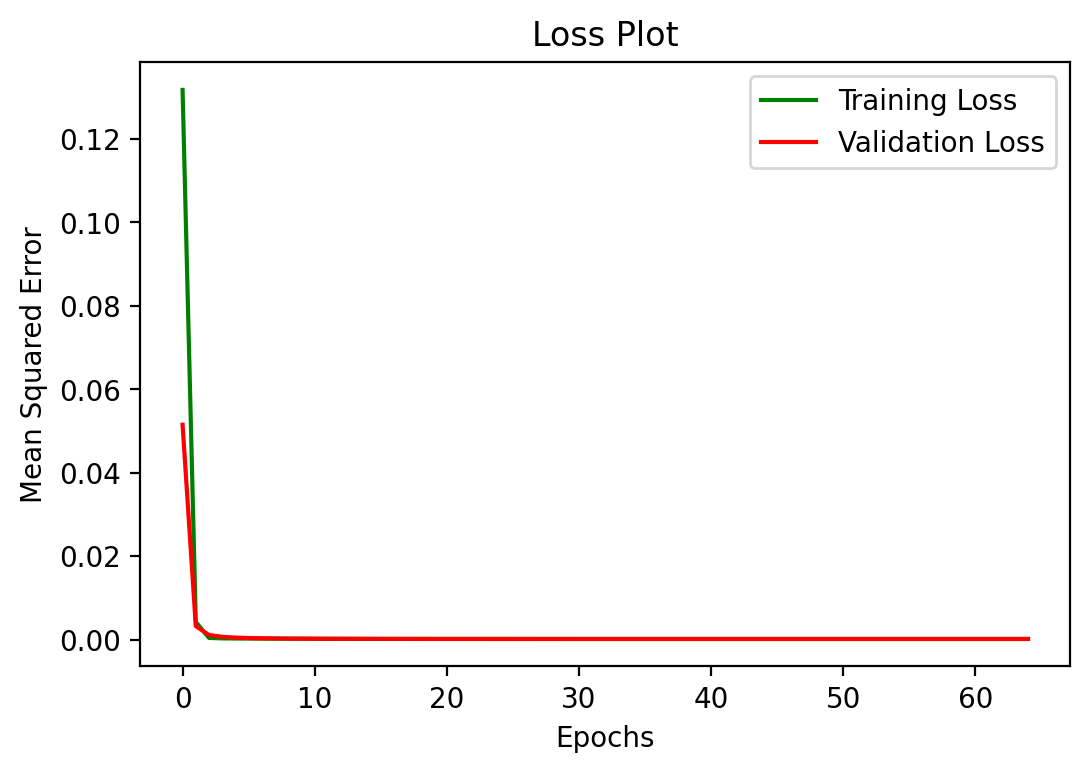

In [21]:
plot_training(history, 'loss')

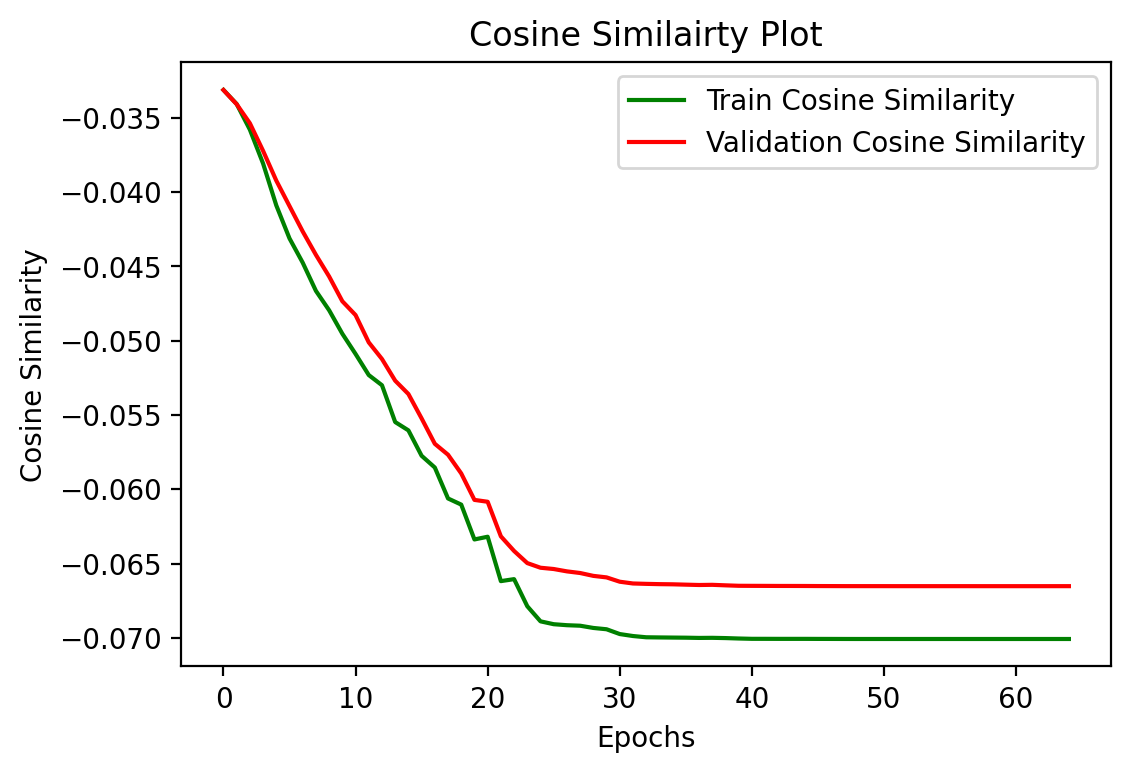

In [22]:
plot_training(history, 'cosine')

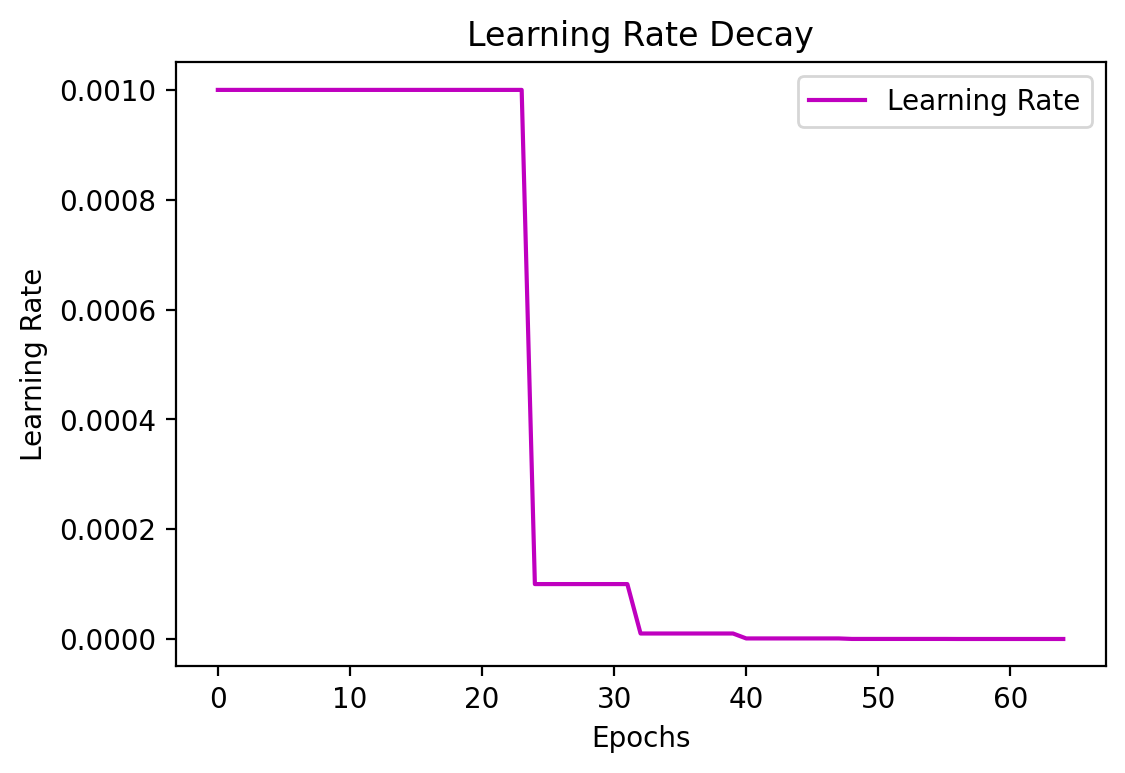

In [28]:
plot_training(history, 'lr')

In [23]:
y_true = sparse.load_npz(stratified_data[3][4]).toarray()[0]
x_pred = np.load(stratified_data[1][4])[0,:,:]
x_pred = np.expand_dims(x_pred, axis = 0)
print(x_pred.shape)

model.load_weights("PeptideNet.h5")

y_pred = model.predict_on_batch(x_pred)

(1, 21, 25)


In [24]:
result = pd.DataFrame({'y_true':y_true.flatten(), 'y_pred':y_pred.flatten()})
result.to_csv('results.csv')

In [25]:
result

,y_true,y_pred
0,0.0,0.004459
1,0.0,0.004433
2,0.0,0.004313
3,0.0,0.004436
4,0.0,0.004380
...,...,...
19995,0.0,0.004310
19996,0.0,0.004338
19997,0.0,0.004395
19998,0.0,0.004472


In [26]:
def cosine_similarity(a,b):
    num = np.dot(a,b)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    
    return num/denom

In [27]:
cosine_similarity(y_true.flatten(), y_pred.flatten())

0.07069867127369